In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
from numpy import inf
from scipy.spatial.distance import pdist
import scipy
from sklearn.decomposition import PCA 
from sklearn.manifold import SpectralEmbedding
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter
import matplotlib
import seaborn as sns
sns.set()
sns.set_context("talk", font_scale = 1.5)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['axes.axisbelow'] = True
matplotlib.rcParams.update({'figure.autolayout': True})

Generate 2-D Diffusion Textures.

In [2]:
l = np.arange(0.8e-5,8e-4,1e-4)
size = 100  # size of the 2D grid
Uend = np.zeros((size,size,len(l)))
p = 0

In [3]:
for a in l: #Iterate over multiple diffusion values
    b = 5e-3
    tau = .1
    k = -.005
    

    dx = 2. / size  # space step
    T = .1 # total time
    dt = .1  # time step
    n = int(T / dt)  # number of iterations
   
    U = np.random.rand(size, size) #Randomly intialize starting conditions.
    V = np.random.rand(size, size)
    
    def laplacian(Z):
        Ztop = Z[0:-2, 1:-1]
        Zleft = Z[1:-1, 0:-2]
        Zbottom = Z[2:, 1:-1]
        Zright = Z[1:-1, 2:]
        Zcenter = Z[1:-1, 1:-1]
        return (Ztop + Zleft + Zbottom + Zright -
                4 * Zcenter) / dx**2
                
    
    def show_patterns(U, ax=None):
        ax.imshow(U, cmap=plt.cm.copper,
                  interpolation='bilinear',
                  extent=[-1, 1, -1, 1])
        ax.set_axis_off()
        
    #    
    #fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    step_plot = n // 18
    # We simulate the PDE with the finite difference
    # method.
    
    Ustore = np.zeros((size,size,n))
    
    Uflat = np.zeros((size*size,n))
    
    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaU = laplacian(U)
        deltaV = laplacian(V)
        # We take the values of u and v inside the grid.
        Uc = U[1:-1, 1:-1]
        Vc = V[1:-1, 1:-1]
        
        # We update the variables.
        U[1:-1, 1:-1], V[1:-1, 1:-1] = \
            Uc + dt * (a * deltaU),\
            Vc + dt * (b * deltaV) 
        
        # Neumann conditions: derivatives at the edges
        # are null.
        for Z in (U, V):
            Z[0, :] = Z[1, :]
            Z[-1, :] = Z[-2, :]
            Z[:, 0] = Z[:, 1]
            Z[:, -1] = Z[:, -2]

        Ustore[:,:,i] = U
        
        Uflat[:,i] = np.ndarray.flatten(U)

    Uend[:,:,p] = (Ustore[:,:,n-1])
    p+=1


Perform morse filtration and smooth resulting diagrams for analysis. Diagrams in this case are smoothed using heat kernel diffusion.

In [4]:
#Create Persistence diagrams through morse filtration on cubical complex:
dottings = []
stores = []
for i in range(len(l)):
    pers = gd.CubicalComplex((size,size),np.ndarray.flatten(Uend[:,:,i]))
    store = pers.persistence()
    dots = np.vstack(pers.persistence_intervals_in_dimension(0))
    dots[dots == inf] = np.max(i)
    dottings.append(dots)
    stores.append(store)

Smooth Diagrams.

In [5]:
gridsize = .02
bins = np.arange(0,1,gridsize)
hist = np.histogram2d(dots[:,0],dots[:,1],bins = bins)
hist = hist[0]
tpoints = []
f = []
weights = []

for i in range(len(bins)-1):
    for j in range(i):
        tpoints.append([j,i])
        c = np.abs(i - j)/2 + j
        weight = np.exp(np.sqrt((i-c)**2 + (j-c)**2))
        f.append(hist[j,i]*weight)

        
tpoints = np.vstack(tpoints)
distmat = scipy.spatial.distance.squareform(pdist(tpoints))

Adj = (distmat <= 6)
Adj = Adj.astype(np.int)
D = np.diag(np.sum(Adj,axis = 1))
L = D - Adj
w,v = np.linalg.eig(L)

ftime = []

for dots in dottings:
    hist = np.histogram2d(dots[:,0],dots[:,1],bins = bins)
    hist = hist[0]
    f = []
    
    for i in range(len(bins)-1):
        for j in range(i):
            c = np.abs(i - j)/2 + j
            weight = (np.sqrt((i-c)**2 + (j-c)**2))
            f.append(hist[j,i]*weight)
    
    ftime.append(f)

diffusers = []
for f in ftime:
    deg = len(tpoints)
    sigma = .04
    deg = len(tpoints)
    fnew = np.asarray(f)     
    exp = np.zeros(len(fnew))
    
    for i in range(deg):
        coef = np.matmul(np.transpose(v[:,i]),fnew)/(len(fnew))
        four = np.exp(-w[i]*sigma)*coef*v[:,i]
        exp = exp + four
     
    exp = exp/exp.max()
    diffusers.append(exp)   

PCA of raw data

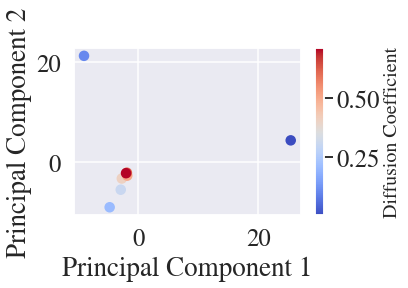

In [6]:
k = np.hstack(l)

pca = PCA()
X = pca.fit_transform(np.transpose(np.vstack(Uend)))

plt.figure()
plt.scatter(X[:,0],X[:,1], c = k*1000, cmap = "coolwarm")
plt.xlabel('Principal Component 1')
cbar = plt.colorbar()
plt.ylabel('Principal Component 2')
cbar.set_label("Diffusion Coefficient", fontsize = 20)

Diffusion Mapping Projection of Raw Data

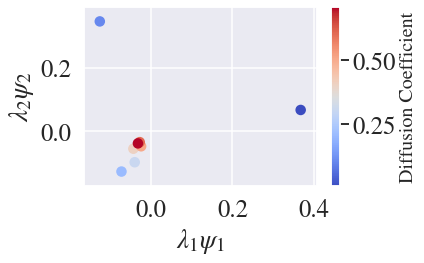

In [7]:
embedding = SpectralEmbedding(affinity = 'rbf')
X = embedding.fit_transform(np.transpose(np.vstack(Uend)))

plt.figure()
plt.scatter(X[:,0],X[:,1], c = k*1000, cmap = "coolwarm")
plt.xlabel('$\lambda_1 \psi_1$')
cbar = plt.colorbar()
plt.ylabel('$\lambda_2 \psi_2$')
cbar.set_label("Diffusion Coefficient", fontsize = 20)

PCA on space of Smoothed PDs

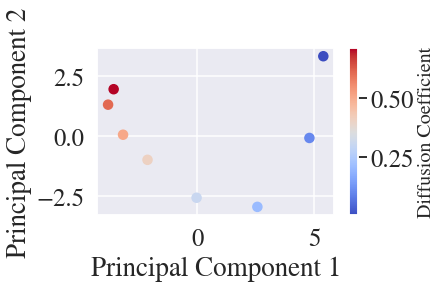

In [8]:
pca = PCA()
X = pca.fit_transform(np.vstack(diffusers))

plt.figure()
plt.scatter(X[:,0],X[:,1], c = k*1000, cmap = "coolwarm")
plt.xlabel('Principal Component 1')
cbar = plt.colorbar()
plt.ylabel('Principal Component 2')
cbar.set_label("Diffusion Coefficient", fontsize = 20)